# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Xiaoxue Zhao

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

In [1]:
!pip install keras

In [2]:
pip install keras tensorflow

Note: you may need to restart the kernel to use updated packages.


We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [4]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

In [5]:
current_palette = sns.color_palette("tab10", 5)
sns.set_palette(current_palette)

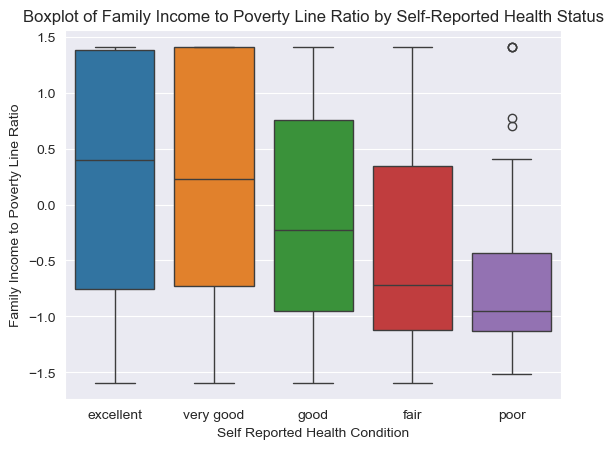

In [6]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled,
                hue = 'HSD010', palette = "tab10")
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

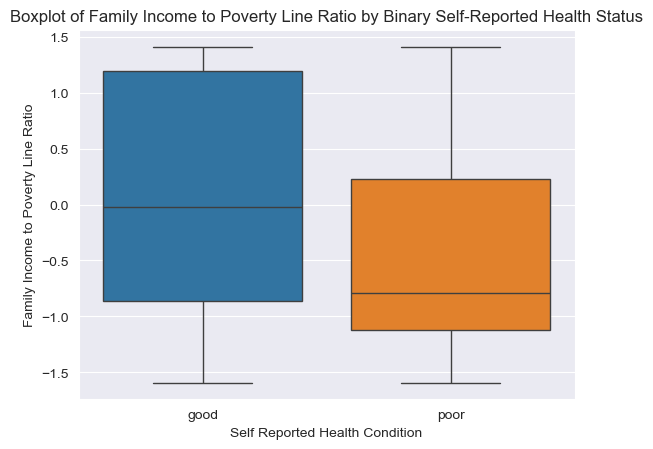

In [7]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled, hue = 'HSD010_binary', palette = "tab10")
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

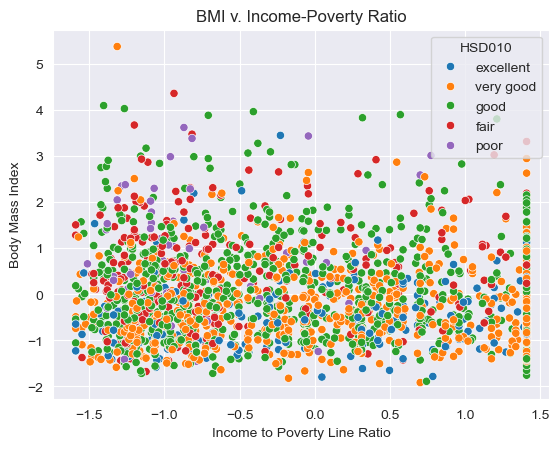

In [8]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [9]:
nhanes_scaled_Binary = nhanes_scaled
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

In [10]:
import tensorflow as tf
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

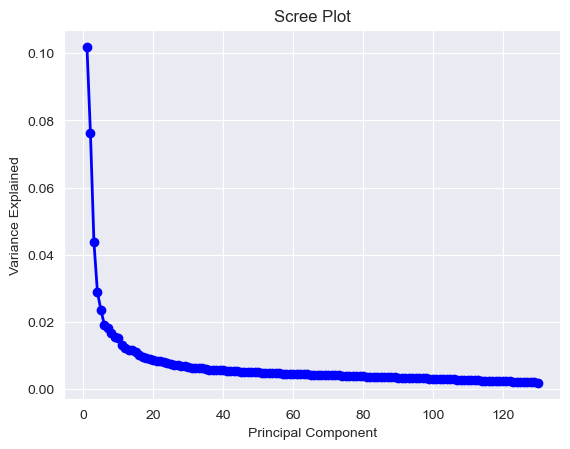

In [11]:
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------

# fit PCA
# ----------
pca_all = PCA(n_components=130)
principalComponents_breast = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

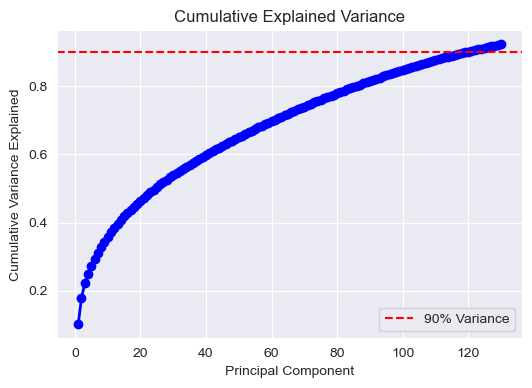

Components for 90% Variance: 120


In [12]:
# cumulative percent of variance explained
# ----------
cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)

plt.figure(figsize=(6, 4))
plt.plot(PC_values, cumulative_variance, 'o-', linewidth=2, color='blue')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.show()

components_for_90_variance = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Components for 90% Variance: {components_for_90_variance}")

### Barplot of Components

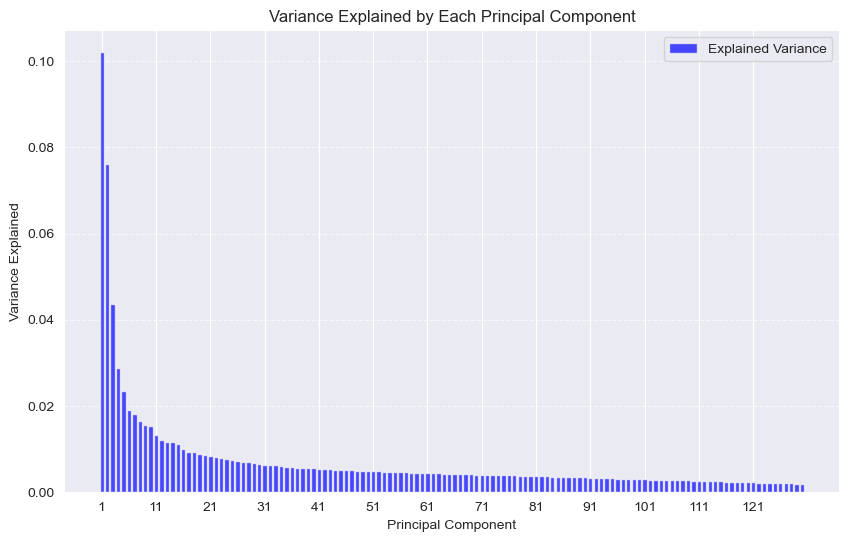

In [13]:
# Barplot of explained variance
# ----------
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca_all.explained_variance_ratio_) + 1), 
        pca_all.explained_variance_ratio_, 
        alpha=0.7, color='blue', 
        label='Explained Variance')
plt.title('Variance Explained by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(pca_all.explained_variance_ratio_) + 1, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### How many components will you use to fit a supervised learning model?

**Choice of the Number of Components: 30 Components**  

From the scree plot, the elbow point appears to be around 30 components. These 30 components capture the key structural features of the data while significantly reducing its dimensionality. This balance ensures that the overall data distribution is preserved, facilitating effective clustering without unnecessary complexity.


However, as shown in *Cumulative Explained Variance Plot*, 120 components are needed to capture 90% variance, which preserves enough information to ensure accurate predictions in the neural network model. As a result, I will include this configurarion into analysis as comparison.

### 2D Scatterplot of the first two components

<Figure size 640x480 with 0 Axes>

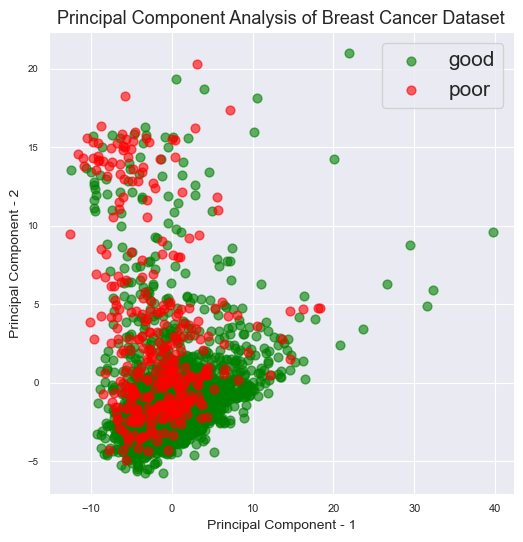

In [14]:
# plot
# ----------
X_2d = pca_all.transform(nhanes_scaled)[:, :2]

# figure settings
plt.figure()
plt.figure(figsize=(6,6))
plt.xticks(fontsize=8)
plt.yticks(fontsize=7)
plt.xlabel('Principal Component - 1',fontsize=10)
plt.ylabel('Principal Component - 2',fontsize=10)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=13)
targets = ['good', 'poor']
colors = ['g', 'r']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = nhanes_scaled_Binary['HSD010_binary'] == target
    plt.scatter(X_2d[indicesToKeep, 0], X_2d[indicesToKeep, 1], c=color, s=40, alpha=.6, label=target)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show()

**Interpretation**  
While the good category (green) shows more concentrated distribution, the poor category (red) is more dispersed. The overlap between the two categories indicates that the first two components alone may not fully distinguish between health states. Some outliers are observed. Additional components or nonlinear analysis may improve separability.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

This is truly a tough decision.

Initially, I considered DBSCAN due to its ability to handle overlapping clusters and detect outliers, considering the overlap in the scatterplot above. However, my experiments showed that DBSCAN resulted in excessive noise points and poorly distributed clusters, especially when applied to the original data-most of the points falling into a single class (cluster 0) and very few points in other clusters (shown in plot *DBSCAN on Original Label: BMI v. Income-Poverty Ratio*). 

My interpretation for this is that DBSCAN is sensitive to the curse of dimensionality. If the data has many features, the Euclidean distance metric becomes less informative, making it hard to detect clusters. So I later implement DBSCAN on PCA result-30 components-and compare it with k-means clustering.

In contrast, K-means provided a more balanced and interpretable outcome. It divided the data into three clusters (0, 1, 2) based on BMI and income-to-poverty ratio. Although the cluster boundaries were somewhat blurred, the cluster sizes and distributions were uniform, offering meaningful groupings for downstream tasks. Furthermore, K-means assigned all data points to clusters, avoiding the high noise levels seen with DBSCAN, which makes it more suitable for tasks like supervised learning.

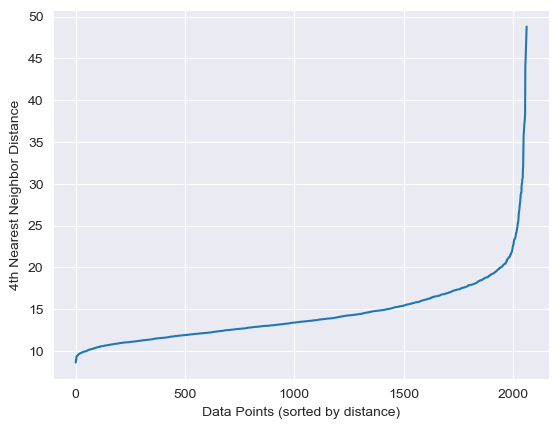

In [15]:
# load library
# ----------
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(nhanes_scaled)
distances, indices = neighbors_fit.kneighbors(nhanes_scaled)
distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.ylabel("4th Nearest Neighbor Distance")
plt.xlabel("Data Points (sorted by distance)")
plt.show()

In [16]:
# define model object
# ----------
dbscan = DBSCAN(eps=10, min_samples=4)

# fit model to data 
# ----------
dbscan.fit(nhanes_scaled)

DBSCAN(eps=10, min_samples=4)

In [17]:
# get fitted labels for each data point 
labels_db = dbscan.labels_
print(np.unique(labels_db, return_counts=True))

(array([-1,  0,  1,  2]), array([1926,  130,    3,    5]))


In [50]:
# define model object on PCA components
# ----------
pca_transformed_30 = pca_all.transform(nhanes_scaled)[:, :30] 
dbscan_PCA = DBSCAN(eps=7, min_samples=4).fit(pca_transformed_30)

In [51]:
# get fitted labels for each data point 
labels_dbscan = dbscan_PCA.labels_
print(np.unique(labels_dbscan, return_counts=True))

(array([-1,  0,  1,  2,  3,  4]), array([ 886, 1157,    7,    6,    4,    4]))


### Cluster nhanes

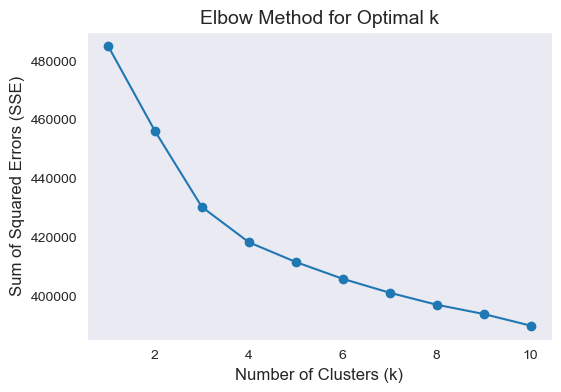

In [20]:
# Calculate SSE for different numbers of clusters
sse = []
for k in range(1, 11):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(nhanes_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid()
plt.show()

Based on the elbow plot, the elbow point is observed at k=3, after k=3, the rate of decrease in SSE starts to slow down, and the curve becomes more gradual. Selecting k=3 is a reasonable choice as it captures the majority of variance in the data while keeping the number of clusters manageable.

In [21]:
# specify kmeans algorithm 
# ----------
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled)

In [22]:
labels_k = kmeans.labels_

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

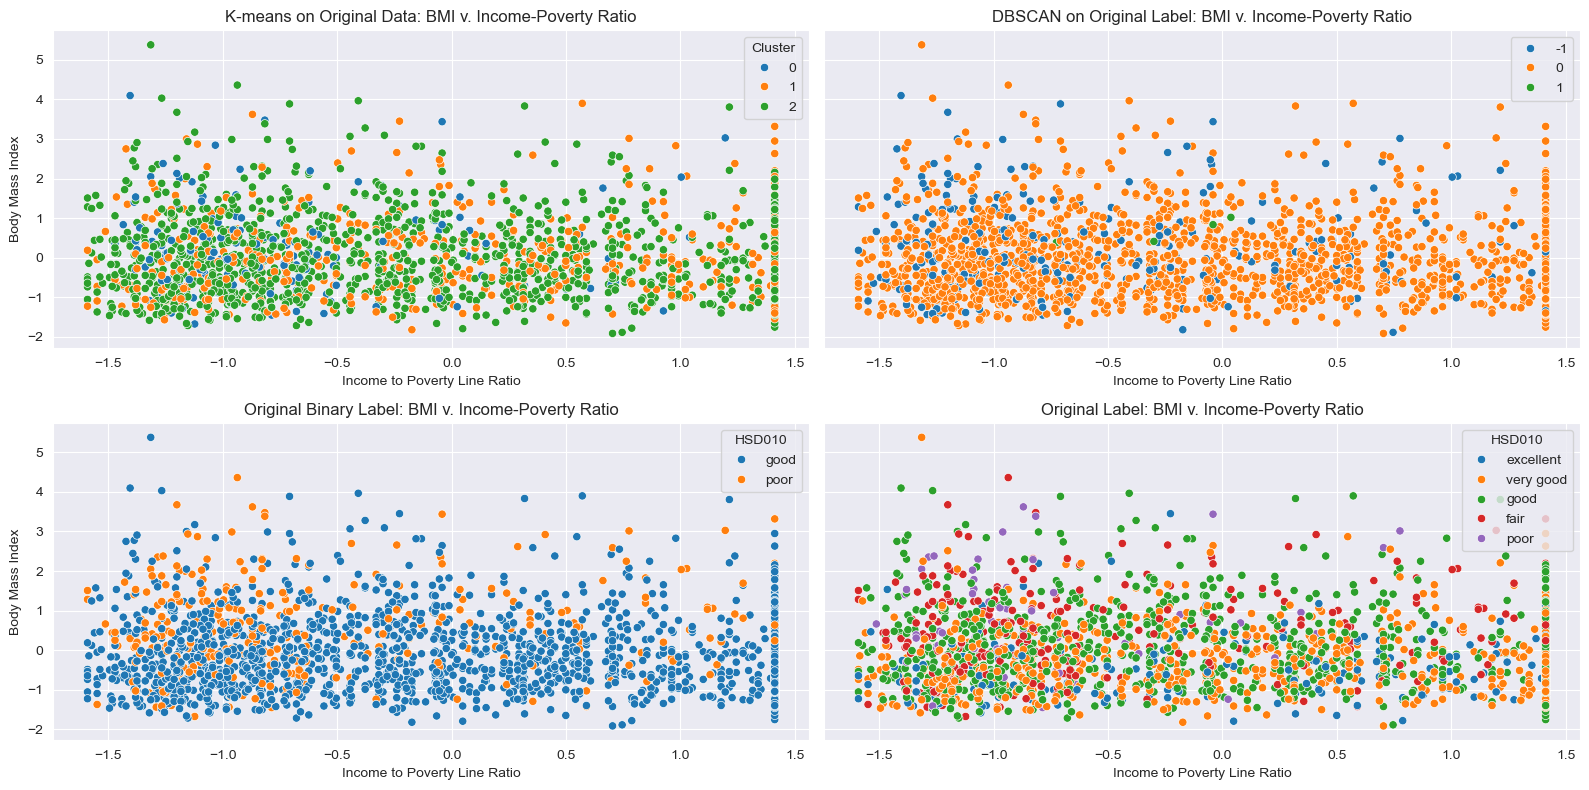

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharey=True)

sns.scatterplot(ax=axes[0, 0], x="INDFMPIR", y="BMXBMI", hue=labels_k, palette="tab10", data=nhanes_scaled)
axes[0, 0].set_title('K-means on Original Data: BMI v. Income-Poverty Ratio')
axes[0, 0].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")

sns.scatterplot(ax=axes[0, 1], x="INDFMPIR", y="BMXBMI", hue=labels_dbscan, palette="tab10", data=nhanes_scaled_Binary)
axes[0, 1].set_title('DBSCAN on Original Label: BMI v. Income-Poverty Ratio')
axes[0, 1].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")

sns.scatterplot(ax=axes[1, 0], x="INDFMPIR", y="BMXBMI", hue="HSD010_binary", palette="tab10", data=nhanes_scaled_Binary)
axes[1, 0].set_title('Original Binary Label: BMI v. Income-Poverty Ratio')
axes[1, 0].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")


sns.scatterplot(ax=axes[1, 1], x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="tab10", data=nhanes_scaled_Binary)
axes[1, 1].set_title('Original Label: BMI v. Income-Poverty Ratio')
axes[1, 1].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")

axes[0, 0].legend(title="Cluster", loc='best')
axes[1, 0].legend(title="HSD010", loc='best')

plt.tight_layout()
plt.show()

**Interpretation on K-means clustering result**
- Cluster Distribution: The three clusters (0, 1, 2) show distinct patterns. Cluster 0 (blue) is concentrated in low BMI and low Income-to-Poverty Ratio regions, Cluster 2 (green) spans a wider horizontal range, and Cluster 1 (orange) overlaps significantly with the others, particularly in areas with moderate BMI and income ratios.
- Cluster Overlap: Cluster 1 overlaps with Cluster 2 in higher BMI regions (2-3) and with Cluster 0 in low BMI and income areas.
- Sparse Data: Data is sparse in higher income ratio regions (>0.5), where Clusters 0 and 2 are less represented, but Cluster 1 still has some presence.

**Comparison with DBSCAN**: K-means divides the data into three clusters (0, 1, 2) based on BMI and income. While the cluster boundaries are somewhat blurred, the clusters are more balanced and evenly distributed, providing a reasonable grouping of the data. Compared to DBSCAN’s high number of noise points, K-means assigns all data points to clusters, which is advantageous for certain downstream tasks such as supervised learning.

**Comparison with original label**: The original HSD010 labels show similar patterns, with “poor” aligning with Cluster 0 and “good/very good” resembling Cluster 1. However, Cluster 2’s broader horizontal distribution is less apparent in HSD010.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

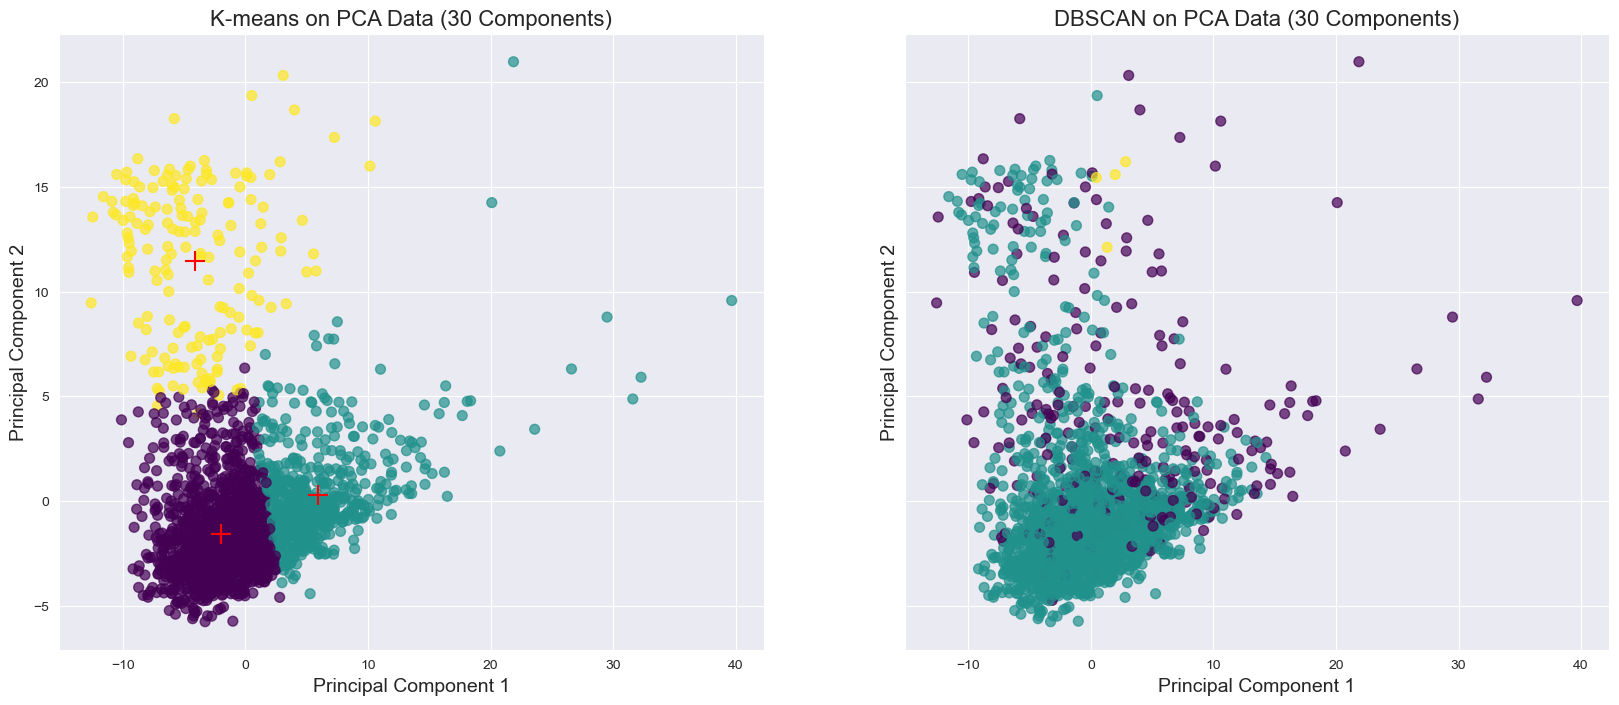

In [24]:
# retrain the clustering using 30 components
# ----------
kmeans_pca30 = KMeans(n_clusters=3,
                    n_init=10,
                    max_iter=300
                   ).fit(pca_transformed_30)

# plot clusters on your 2D scatter
# ----------
labels_pca30 = kmeans_pca30.labels_
cluster_centers_pca30 = kmeans_pca30.cluster_centers_

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

axes[0].scatter(pca_transformed_30[:, 0], pca_transformed_30[:, 1], c=labels_pca30, cmap='viridis', s=50, alpha=0.7)
axes[0].scatter(cluster_centers_pca30[:, 0], cluster_centers_pca30[:, 1], c='red', marker='+', s=200, label='Cluster Centers')

axes[0].set_title('K-means on PCA Data (30 Components)', fontsize=16)
axes[0].set_xlabel('Principal Component 1', fontsize=14)
axes[0].set_ylabel('Principal Component 2', fontsize=14)

axes[1].scatter(pca_transformed_30[:, 0], pca_transformed_30[:, 1], c=labels_dbscan, cmap='viridis', s=50, alpha=0.7)

axes[1].set_title('DBSCAN on PCA Data (30 Components)', fontsize=16)
axes[1].set_xlabel('Principal Component 1', fontsize=14)
axes[1].set_ylabel('Principal Component 2', fontsize=14)

plt.show()

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

I choose ***hsd010_binary*** as the target outcome because the subjective nature of self-reported health assessments makes the distinctions between categories like “fair,” “good,” and “very good” subtle and potentially inconsistent. By reducing the target to a binary outcome, we focus on a more meaningful and robust differentiation, which is better suited for training a neural network.

In [25]:
# partition data
# -----------
y = nhanes_scaled_Binary['HSD010_binary'].replace(['good', 'poor'], [0, 1]) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

/var/folders/gz/txr1ywf13ss49jh8_z6ygy4h0000gn/T/ipykernel_6668/293913527.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = nhanes_scaled_Binary['HSD010_binary'].replace(['good', 'poor'], [0, 1]) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already


In [26]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = len(np.unique(y))
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes = y_test.shape[1]

In [27]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))

model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))

## Add any additional layers you wish here

model.add(Dense(2, kernel_initializer='he_uniform', activation='softmax'))  # output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6697 - loss: 0.6859 - val_accuracy: 0.8275 - val_loss: 0.4251
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8876 - loss: 0.2976 - val_accuracy: 0.8295 - val_loss: 0.3938
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.9239 - loss: 0.2251 - val_accuracy: 0.8391 - val_loss: 0.3857
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9415 - loss: 0.1765 - val_accuracy: 0.8275 - val_loss: 0.3889
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.9587 - loss: 0.1396 - val_accuracy: 0.8275 - val_loss: 0.4023
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.9767 - loss: 0.1080 - val_accuracy: 0.8295 - val_loss: 0.4206
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9854 - loss: 0.0823 - val_accuracy: 0.8295 - val_loss: 0.4448
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0639 - val_accuracy: 0.8314 - val_loss: 0.

### Neural Network on Principal Components

In [28]:
pca_transformed30 = pca_all.transform(nhanes_scaled)[:, :30]  # top 30 components

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_transformed30, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)
y_train_pca = keras.utils.to_categorical(y_train_pca, num_classes=num_classes)
y_test_pca = keras.utils.to_categorical(y_test_pca, num_classes=num_classes)

model_pca = Sequential()

model_pca.add(Dense(64, input_dim=X_train_pca.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_pca.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
model_pca.add(Dense(2, kernel_initializer='he_uniform', activation='softmax'))

model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_pca.fit(X_train_pca, y_train_pca, validation_data=(X_test_pca, y_test_pca), epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7179 - loss: 0.8383 - val_accuracy: 0.7791 - val_loss: 0.5307
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8372 - loss: 0.4495 - val_accuracy: 0.7946 - val_loss: 0.4797
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8537 - loss: 0.3869 - val_accuracy: 0.8101 - val_loss: 0.4527
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8724 - loss: 0.3474 - val_accuracy: 0.8295 - val_loss: 0.4353
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8797 - loss: 0.3170 - val_accuracy: 0.8275 - val_loss: 0.4255
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8882 - loss: 0.2942 - val_accuracy: 0.8314 - val_loss: 0.4217
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.8963 - loss: 0.2773 - val_accuracy: 0.8275 - val_loss: 0.4196
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.9039 - loss: 0.2626 - val_accuracy: 0.8333 - val_loss: 0.4201

In [29]:
pca_transformed120 = pca_all.transform(nhanes_scaled)[:, :120]  # top 120 components

X_train_pca120, X_test_pca120, y_train_pca120, y_test_pca120 = train_test_split(pca_transformed120, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)
y_train_pca120 = keras.utils.to_categorical(y_train_pca120, num_classes=num_classes)
y_test_pca120 = keras.utils.to_categorical(y_test_pca120, num_classes=num_classes)

model_pca120 = Sequential()

model_pca120.add(Dense(64, input_dim=X_train_pca120.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_pca120.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
model_pca120.add(Dense(2, kernel_initializer='he_uniform', activation='softmax'))

model_pca120.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_pca120.fit(X_train_pca120, y_train_pca120, validation_data=(X_test_pca120, y_test_pca120), epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8051 - loss: 0.6187 - val_accuracy: 0.8411 - val_loss: 0.4146
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8850 - loss: 0.3212 - val_accuracy: 0.8527 - val_loss: 0.3872
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9063 - loss: 0.2464 - val_accuracy: 0.8488 - val_loss: 0.3777
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9309 - loss: 0.2047 - val_accuracy: 0.8488 - val_loss: 0.3754
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9467 - loss: 0.1723 - val_accuracy: 0.8469 - val_loss: 0.3780
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9585 - loss: 0.1459 - val_accuracy: 0.8488 - val_loss: 0.3837
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9708 - loss: 0.1238 - val_accuracy: 0.8547 - val_loss: 0.3905
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9784 - loss: 0.1047 - val_accuracy: 0.8547 - val_loss: 0.4001
Epo

### Neural Network on Principal Components + Cluster Membership

In [30]:
combined_features = np.hstack((pca_transformed30, labels_k.reshape(-1, 1)))
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(combined_features,
                                                                        y,
                                                                        test_size=0.25,
                                                                        random_state=10)
y_train_comb = to_categorical(y_train_comb, num_classes=2)
y_test_comb = to_categorical(y_test_comb, num_classes=2)

model_comb = Sequential()

model_comb.add(Dense(64, input_dim=X_train_comb.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_comb.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
model_comb.add(Dense(2, kernel_initializer='he_uniform', activation='softmax'))

model_comb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_comb.fit(X_train_comb, y_train_comb, validation_data=(X_test_comb, y_test_comb), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7413 - loss: 0.8711 - val_accuracy: 0.7926 - val_loss: 0.5259
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8610 - loss: 0.3978 - val_accuracy: 0.8256 - val_loss: 0.4493
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.8746 - loss: 0.3257 - val_accuracy: 0.8411 - val_loss: 0.4225
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.8856 - loss: 0.2985 - val_accuracy: 0.8391 - val_loss: 0.4099
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.8943 - loss: 0.2814 - val_accuracy: 0.8353 - val_loss: 0.4014
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9001 - loss: 0.2662 - val_accuracy: 0.8353 - val_loss: 0.3968
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.9041 - loss: 0.2542 - val_accuracy: 0.8333 - val_loss: 0.3935
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.9051 - loss: 0.2435 - val_accuracy: 0.8295 -

In [31]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss_pca, accuracy_pca30 = model_pca.evaluate(X_test_pca, y_test_pca, verbose=0)
loss_pca, accuracy_pca120 = model_pca120.evaluate(X_test_pca120, y_test_pca120, verbose=0)
loss_comb, accuracy_comb = model_comb.evaluate(X_test_comb, y_test_comb, verbose=0)

print(f"Test Accuracy on Original Features: {accuracy:.4f}")
print(f"Test Accuracy on 30 PCA Features: {accuracy_pca30:.4f}")
print(f"Test Accuracy on 120 PCA Features: {accuracy_pca120:.4f}")
print(f"Test Accuracy on PCA + Cluster Features: {accuracy_comb:.4f}")

Test Accuracy on Original Features: 0.8295
Test Accuracy on 30 PCA Features: 0.8004
Test Accuracy on 120 PCA Features: 0.8469
Test Accuracy on PCA + Cluster Features: 0.8198


**Interpretation of Results**

The results reveal how different feature engineering techniques impact model performance:
- Original Features: The accuracy of 0.8295 demonstrates that retaining all original features preserves the dataset’s full complexity. However, it also introduces challenges like handling redundant and correlated features, which can hinder generalization.
- 30 PCA Features: With an accuracy of 0.8004, using only 30 principal components reduced performance significantly. This indicates that while dimensionality reduction simplifies the dataset and potentially mitigates overfitting, it risks discarding critical information when too few components are retained.
- 120 PCA Features: The highest accuracy of 0.8469 was achieved using 120 components, suggesting that retaining a larger number of principal components preserves more useful information for prediction. This configuration was specifically included because 90% of the variance was explained only when using 120 components, as shown in the cumulative explained variance analysis. However, the inclusion of such a large number of components could potentially increase the risk of overfitting, highlighting the tradeoff between information retention and model complexity.
- PCA + Clustering Features: Combining clustering labels with PCA-transformed features resulted in an accuracy of 0.8198, which was higher than using 30 PCA components alone. This improvement indicates that clustering features contributed additional information that complemented the reduced feature space. However, the performance was still lower than the 120 PCA configuration, suggesting that clustering features may provide limited benefits when richer information is already available.

These results demonstrate that balancing the number of principal components is crucial for avoiding both underfitting and overfitting. Additionally, clustering features can provide meaningful improvements when aligned well with the target variable, as seen in the PCA + clustering configuration.

**Reflection**

You can read my reflection [here](./reflection.md).

## Discussion Questions

**1. In your own words, what is the difference between PCA and clustering?**

PCA and clustering served different purposes in this project. PCA was used to reduce the dimensionality of the original features, transforming them into a set of principal components that captured most of the variance in the data. In other words, PCA is used to abandon having redundant features, simplifying the data structure while preserving as much information as possible. For example, we retained 120 principal components, which represented a large proportion of the original variance.

In contrast, clustering (e.g., K-means and DBSCAN) aimed to group data points into clusters based on their similarities, independent of the target variable. For instance, in our analysis, K-means grouped the data into three clusters, while DBSCAN identified a significant number of noise points, reflecting the differences in their approaches. PCA focused on simplifying the feature space, while clustering attempted to uncover inherent group structures in the data.

**2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?**

Combining PCA and clustering showed mixed results throughout the project. In one instance, the PCA + clustering configuration achieved a higher accuracy than the original data. This suggests that clustering features can provide additional structure and information to the model, which might help when the original data contains redundant or noisy features. However, this result was not consistently replicable, likely due to the randomness in clustering outputs or model initialization.

In the final analysis, PCA + clustering resulted in an accuracy of 0.8198, which was higher than using only 30 PCA components (0.8004) but lower than using the original features (0.8295) or 120 PCA components (0.8469). This indicates that clustering features contributed meaningfully to the reduced feature space of 30 PCA components, partially compensating for the information lost during dimensionality reduction. 

The variability in results also points to a key challenge: ensuring the alignment of clustering outputs with the target variable. If the clustering process produces groupings that don’t reflect meaningful patterns for prediction, their contribution to the model may be minimal. This highlights the importance of carefully selecting and tuning unsupervised techniques to maximize their benefits in specific contexts.

My guess for this is that neural networks are inherently effective at performing dimensionality reduction in internal layers. As a result, adding PCA might have removed information that the neural network could have otherwise used. Thus we would not gain anything from combining PCA and clustering. Furthermore, the dataset itself contains a mix of correlated and uncorrelated features, and clustering may not have aligned well with the structure of the target variable. Nevertheless, though after applying PCA and clustering I didn't get expected enhanced result, it still make sense to definitely try to apply PCA to investigate it works or not, as the success of these methods highly depends on the specific dataset and problem.

**3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"**

Unsupervised techniques like PCA and clustering can significantly assist in handling “big data” by reducing the dimensionality of the data and uncovering hidden patterns. For instance, in this project, PCA reduced the dataset to 30 components, improving computational efficiency and potentially mitigating the curse of dimensionality. This dimensionality reduction also serves as a form of regularization, reducing the risk of overfitting when training neural networks.

Moreover, clustering can reveal latent structures or groupings in the data, which may be used as additional features to enhance model performance. In practice, neural networks often rely on gradient-based optimization, which benefits from a well-conditioned input space. Transformations like PCA help center, scale, and simplify the data, improving convergence speed and the quality of results. While our project showed limited gains from clustering, it highlighted the potential of these techniques to improve data preprocessing and downstream learning when carefully aligned with the problem.